In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load ESC-50 metadata
esc50_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
esc50_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"

metadata = pd.read_csv(esc50_csv_path)

def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if len(y) < sr * 0.1:
            print(f"Skipping short audio file: {file_path}")
            return None
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        def resize_feature(feature, target_size):
            return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                     (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

        mel_spec = resize_feature(mel_spec, target_size)
        chroma = resize_feature(chroma, target_size)
        spectral_contrast = resize_feature(spectral_contrast, target_size)

        stacked_features = np.stack([mel_spec, chroma, spectral_contrast], axis=-1)
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

X, y = [], []
for i in tqdm(range(len(metadata))):
    file_path = os.path.join(esc50_audio_dir, metadata.loc[i, "filename"])
    label = metadata.loc[i, "target"]
    if not os.path.exists(file_path):
        print(f"Skipping missing file: {file_path}")
        continue
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

if len(X) == 0:
    raise RuntimeError("No valid audio files were processed. Check dataset paths and file integrity.")

X = np.array(X)
y = to_categorical(y, num_classes=50)
X_resized = np.array([tf.image.resize(img, (128, 128)).numpy() for img in X])
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

class ESC50ModelTrainer:
    def __init__(self, input_shape=(128, 128, 3), num_classes=50):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding='same', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1024))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(Dense(self.num_classes, activation='softmax'))
        return model

    def compile_model(self):
        self.model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

trainer = ESC50ModelTrainer()
trainer.compile_model()
model = trainer.model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Save the trained model
model.save("/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/esc50_model.h5")
print("Model saved successfully as esc50_model.h5")

# Load the model later if needed
loaded_model = load_model("/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/esc50_model.h5")

# Evaluate model on training and test data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Validation Accuracy: {test_accuracy:.4f}")


  2%|▏         | 38/2000 [01:01<21:22,  1.53it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [23:14<00:00,  1.43it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.1019 - loss: 3.6401 - val_accuracy: 0.0225 - val_loss: 3.9021
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2539 - loss: 2.6380 - val_accuracy: 0.0450 - val_loss: 3.6599
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3538 - loss: 2.2064 - val_accuracy: 0.1150 - val_loss: 3.3454
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.4171 - loss: 1.9286 - val_accuracy: 0.2250 - val_loss: 3.0089
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4795 - loss: 1.7925 - val_accuracy: 0.2625 - val_loss: 2.7252
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5193 - loss: 1.6205 - val_accuracy: 0.3250 - val_loss: 2.4512
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5453 - loss: 1.4713 - val_accuracy: 0.2150 - val_loss: 3.0931
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5895 - loss: 1.3358 - val_accuracy: 0.2400 - v

Test Accuracy: 0.5375
Model saved successfully as esc50_model.h5


Training Accuracy: 0.7675
Validation Accuracy: 0.5375


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load ESC-50 trained model
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/esc50_model.h5"
if not os.path.exists(esc50_model_path):
    raise FileNotFoundError(f"ESC-50 trained model not found at: {esc50_model_path}")
base_model = load_model(esc50_model_path)

# Define new input layer to properly wrap the pre-trained model
input_layer = Input(shape=(128, 128, 3))
x = base_model(input_layer, training=False)  # Pass input through pre-trained model
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(10, activation='softmax')(x)  # UrbanSound8K has 10 classes

urban_model = Model(inputs=input_layer, outputs=out)
urban_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Load UrbanSound8K dataset
urbansound_csv = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
if not os.path.exists(urbansound_csv):
    raise FileNotFoundError(f"UrbanSound8K metadata file not found at: {urbansound_csv}")

urbandata = pd.read_csv(urbansound_csv)
audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if len(y) < sr * 0.1 or np.sum(y) == 0:
            print(f"Skipping silent or short audio file: {file_path}")
            return None

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        time_steps = mel_spec.shape[1]  # Ensure all features match this width

        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12) if np.any(y) else np.zeros((12, time_steps))

        # Further restrict `n_bands` to avoid exceeding Nyquist frequency limit
        max_possible_bands = int(np.floor(np.log2(sr / 2 / 20)))  # Safe limit
        n_bands = min(2, max_possible_bands)  # Reduce to 2 bands
        fmin = max(20, sr / (2 * (n_bands + 1)))  # Ensure fmin is valid

        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=n_bands, fmin=fmin) if np.any(y) else np.zeros((n_bands, time_steps))

        def resize_feature(feature, target_size):
            return tf.image.resize(np.expand_dims(feature, axis=-1), target_size).numpy().squeeze()

        mel_spec = resize_feature(mel_spec, target_size)
        chroma = resize_feature(chroma, target_size)
        spectral_contrast = resize_feature(spectral_contrast, target_size)

        stacked_features = np.stack([mel_spec, chroma, spectral_contrast], axis=-1)

        # Ensure shape consistency before returning
        if stacked_features.shape != (128, 128, 3):
            print(f"Skipping due to inconsistent shape: {stacked_features.shape} for file {file_path}")
            return None

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

X_urban, y_urban = [], []
print("Processing UrbanSound8K dataset...")
for _, row in tqdm(urbandata.iterrows(), total=len(urbandata)):
    file_path = os.path.join(audio_dir, f"fold{row['fold']}", row['slice_file_name'])
    label = row['classID']
    if not os.path.exists(file_path):
        print(f"Skipping missing file: {file_path}")
        continue
    features = extract_features(file_path)
    if features is not None:
        X_urban.append(features)
        y_urban.append(label)

if len(X_urban) == 0:
    raise RuntimeError("No valid audio files were processed. Check dataset paths and file integrity.")

# Convert to NumPy arrays safely
X_urban = np.asarray(X_urban)
y_urban = to_categorical(y_urban, num_classes=10)

print(f"Dataset successfully processed! {X_urban.shape[0]} samples available.")

# Ensure dataset splitting happens correctly
if len(X_urban) > 0:
    X_train_urban, X_test_urban, y_train_urban, y_test_urban = train_test_split(X_urban, y_urban, test_size=0.2, random_state=42)
    print(f"Training set: {X_train_urban.shape}, Test set: {X_test_urban.shape}")

    # Train modified model on UrbanSound8K
    history = urban_model.fit(X_train_urban, y_train_urban, validation_data=(X_test_urban, y_test_urban), epochs=50, batch_size=32)

    # Save the fine-tuned model
    urban_model.save("/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/urbansound8k_model.h5")
    print("Fine-tuned model saved successfully as urbansound8k_model.h5")
else:
    print("No valid training data available. Check feature extraction.")


Processing UrbanSound8K dataset...


  1%|          | 66/8732 [00:06<09:04, 15.92it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 24%|██▍       | 2126/8732 [02:43<04:51, 22.65it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold3/151359-1-2-0.wav


 41%|████      | 3558/8732 [04:38<05:02, 17.13it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold2/17307-1-0-0.wav


 95%|█████████▌| 8331/8732 [10:43<00:12, 32.59it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-1-0.wav
Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-2-0.wav
Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-3-0.wav
Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-4-0.wav


100%|██████████| 8732/8732 [11:12<00:00, 12.99it/s]


Dataset successfully processed! 8726 samples available.
Training set: (6980, 128, 128, 3), Test set: (1746, 128, 128, 3)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.2167 - loss: 2.3319 - val_accuracy: 0.4055 - val_loss: 2.1246
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.4563 - loss: 1.5991 - val_accuracy: 0.5074 - val_loss: 1.7342
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.5417 - loss: 1.3704 - val_accuracy: 0.5326 - val_loss: 1.4023
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.5910 - loss: 1.2503 - val_accuracy: 0.5687 - val_loss: 1.2977
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.6242 - loss: 1.1592 - val_accuracy: 0.5773 - val_loss: 1.2824
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.6519 - loss: 1.0975 - val_accuracy: 0.6191 - val_loss: 1.1444
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.6748 - loss: 1.0210 - val_accuracy: 0.

Fine-tuned model saved successfully as urbansound8k_model.h5


Training Accuracy: 0.8923
Test Accuracy: 0.8505
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step
Precision: 0.8555
Recall: 0.8505
F1 Score: 0.8480


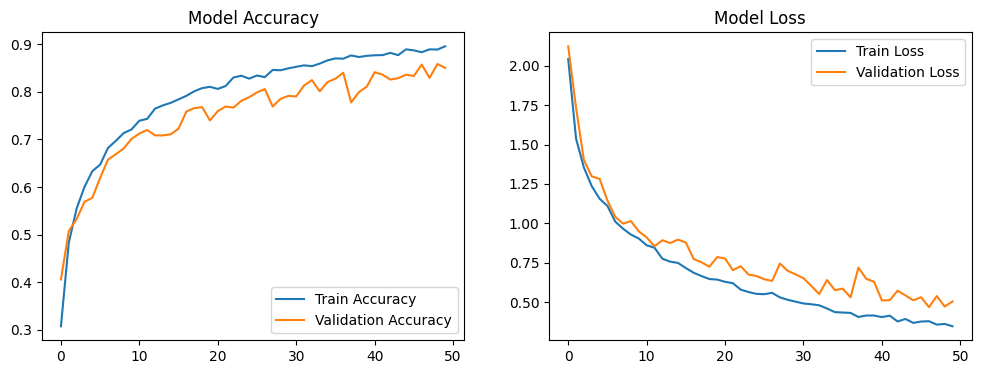

y_true_classes: <class 'numpy.ndarray'> (1746,)
y_pred_classes: <class 'numpy.ndarray'> (1746,)

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       215
           1       0.84      0.87      0.86        79
           2       0.88      0.59      0.70       178
           3       0.91      0.78      0.84       209
           4       0.82      0.90      0.86       212
           5       0.84      0.86      0.85       204
           6       1.00      0.91      0.95        68
           7       0.89      0.85      0.87       191
           8       0.91      0.92      0.91       170
           9       0.80      0.88      0.84       220

    accuracy                           0.85      1746
   macro avg       0.87      0.85      0.85      1746
weighted avg       0.86      0.85      0.85      1746

Final Test Accuracy (from classification report): 0.8505


In [ ]:
# Evaluate model on training data
train_loss, train_accuracy = urban_model.evaluate(X_train_urban, y_train_urban, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate model on test data
test_loss, test_accuracy = urban_model.evaluate(X_test_urban, y_test_urban, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_probs = urban_model.predict(X_test_urban)  # Get probability outputs
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_classes = np.argmax(y_test_urban, axis=1)  # Convert one-hot encoded labels to class labels


from sklearn.metrics import precision_score, recall_score, f1_score


# Compute precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


# Ensure the import is available
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Debugging step: Check class labels before computing classification report
print("y_true_classes:", type(y_true_classes), y_true_classes.shape)
print("y_pred_classes:", type(y_pred_classes), y_pred_classes.shape)

# Compute classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)])

print("\nClassification Report:\n")
print(report)
print(f"Final Test Accuracy (from classification report): {accuracy_score(y_true_classes, y_pred_classes):.4f}")



Processing UrbanSound8K dataset...


  1%|          | 67/8732 [01:09<2:41:09,  1.12s/it]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 24%|██▍       | 2123/8732 [19:32<42:03,  2.62it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold3/151359-1-2-0.wav


 41%|████      | 3556/8732 [32:12<33:53,  2.55it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold2/17307-1-0-0.wav


 95%|█████████▌| 8327/8732 [1:12:59<02:44,  2.46it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-1-0.wav


 95%|█████████▌| 8328/8732 [1:13:00<02:38,  2.54it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-2-0.wav


 95%|█████████▌| 8329/8732 [1:13:00<02:32,  2.65it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-3-0.wav


 95%|█████████▌| 8330/8732 [1:13:00<02:21,  2.85it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-4-0.wav


100%|██████████| 8732/8732 [1:16:22<00:00,  1.91it/s]


Dataset successfully processed! 8726 samples available.
Training set: (6980, 128, 128, 3), Test set: (1746, 128, 128, 3)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.2465 - loss: 2.2606 - val_accuracy: 0.4364 - val_loss: 2.1116
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5030 - loss: 1.5621 - val_accuracy: 0.5189 - val_loss: 1.7196
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.5896 - loss: 1.3021 - val_accuracy: 0.5601 - val_loss: 1.3561
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.6257 - loss: 1.2021 - val_accuracy: 0.5762 - val_loss: 1.3074
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6526 - loss: 1.1170 - val_accuracy: 0.6266 - val_loss: 1.1876
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.6682 - loss: 1.0638 - val_accuracy: 0.6415 - val_loss: 1.1254
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.6960 - loss: 0.9884 - val_accuracy: 0.

Fine-tuned model saved successfully as urbansound8k_model.h5


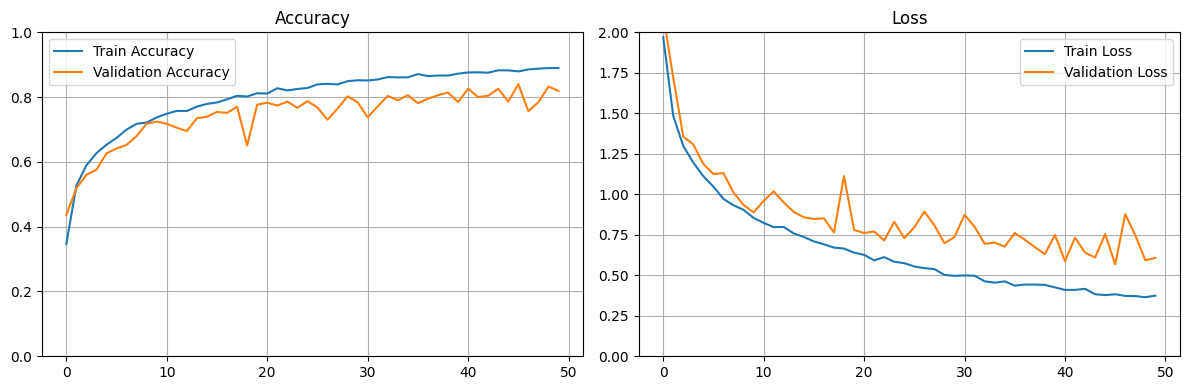

CNN2 training history saved!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load ESC-50 trained model
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/esc50_model.h5"
if not os.path.exists(esc50_model_path):
    raise FileNotFoundError(f"ESC-50 trained model not found at: {esc50_model_path}")
base_model = load_model(esc50_model_path)

# Define new input layer to properly wrap the pre-trained model
input_layer = Input(shape=(128, 128, 3))
x = base_model(input_layer, training=False)  # Pass input through pre-trained model
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(10, activation='softmax')(x)  # UrbanSound8K has 10 classes

urban_model = Model(inputs=input_layer, outputs=out)
urban_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Load UrbanSound8K dataset
urbansound_csv = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
if not os.path.exists(urbansound_csv):
    raise FileNotFoundError(f"UrbanSound8K metadata file not found at: {urbansound_csv}")

urbandata = pd.read_csv(urbansound_csv)
audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if len(y) < sr * 0.1 or np.sum(y) == 0:
            print(f"Skipping silent or short audio file: {file_path}")
            return None

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        time_steps = mel_spec.shape[1]  # Ensure all features match this width

        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12) if np.any(y) else np.zeros((12, time_steps))

        # Further restrict `n_bands` to avoid exceeding Nyquist frequency limit
        max_possible_bands = int(np.floor(np.log2(sr / 2 / 20)))  # Safe limit
        n_bands = min(2, max_possible_bands)  # Reduce to 2 bands
        fmin = max(20, sr / (2 * (n_bands + 1)))  # Ensure fmin is valid

        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=n_bands, fmin=fmin) if np.any(y) else np.zeros((n_bands, time_steps))

        def resize_feature(feature, target_size):
            return tf.image.resize(np.expand_dims(feature, axis=-1), target_size).numpy().squeeze()

        mel_spec = resize_feature(mel_spec, target_size)
        chroma = resize_feature(chroma, target_size)
        spectral_contrast = resize_feature(spectral_contrast, target_size)

        stacked_features = np.stack([mel_spec, chroma, spectral_contrast], axis=-1)

        # Ensure shape consistency before returning
        if stacked_features.shape != (128, 128, 3):
            print(f"Skipping due to inconsistent shape: {stacked_features.shape} for file {file_path}")
            return None

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

X_urban, y_urban = [], []
print("Processing UrbanSound8K dataset...")
for _, row in tqdm(urbandata.iterrows(), total=len(urbandata)):
    file_path = os.path.join(audio_dir, f"fold{row['fold']}", row['slice_file_name'])
    label = row['classID']
    if not os.path.exists(file_path):
        print(f"Skipping missing file: {file_path}")
        continue
    features = extract_features(file_path)
    if features is not None:
        X_urban.append(features)
        y_urban.append(label)

if len(X_urban) == 0:
    raise RuntimeError("No valid audio files were processed. Check dataset paths and file integrity.")

# Convert to NumPy arrays safely
X_urban = np.asarray(X_urban)
y_urban = to_categorical(y_urban, num_classes=10)

print(f"Dataset successfully processed! {X_urban.shape[0]} samples available.")

# Ensure dataset splitting happens correctly
if len(X_urban) > 0:
    X_train_urban, X_test_urban, y_train_urban, y_test_urban = train_test_split(X_urban, y_urban, test_size=0.2, random_state=42)
    print(f"Training set: {X_train_urban.shape}, Test set: {X_test_urban.shape}")

    # Train modified model on UrbanSound8K
    history = urban_model.fit(X_train_urban, y_train_urban, validation_data=(X_test_urban, y_test_urban), epochs=50, batch_size=32)

    # Save the fine-tuned model
    urban_model.save("/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/urbansound8k_model.h5")
    print("Fine-tuned model saved successfully as urbansound8k_model.h5")
else:
    print("No valid training data available. Check feature extraction.")



# Plot Training History
# ============================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ============================
# Save Training History as .npy
# ============================
result_dir = "/content/drive/MyDrive/Colab Notebooks/Models/Result"
np.save(os.path.join(result_dir, "cnn2_LM_SPC_CH_train_acc.npy"), history.history['accuracy'])
np.save(os.path.join(result_dir, "cnn2_LM_SPC_CH_val_acc.npy"), history.history['val_accuracy'])
np.save(os.path.join(result_dir, "cnn2_LM_SPC_CH_train_loss.npy"), history.history['loss'])
np.save(os.path.join(result_dir, "cnn2_LM_SPC_CH_val_loss.npy"), history.history['val_loss'])

print("CNN2 training history saved!")